# Random Forest Hyperparameter Tuning

Neben XGBoost wurde auch Random Forest als eins der geeigneten Modelle identifiziert. In diesem Notebook wird nun das Random Forest-Modell optimiert.

In [1]:
import helper
from helper import *
import importlib
importlib.reload(helper)

df = load_merged_data(only_standard_refuelling=True)

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
input_columns = [
    'refuellingTimePoint', 'refuellingTimePoint_5', 'refuellingTimePoint_10', 'refuellingTimePoint_15', 'refuellingTimePoint_30', 'refuellingTimePoint_60',
    'bufferChargingDegree', 'bufferChargingDegree_5', 'bufferChargingDegree_10', 'bufferChargingDegree_15', 'bufferChargingDegree_30', 'bufferChargingDegree_60',
    'Anheizen', 'Anzünden', 'Ausbrennen', 'Ausgeschaltet', 'Automatik', 'Vorbelüften', 'Zündung bereit',
    'Year sin', 'Year cos',
    'refuellingQuantity',
    'residualOxygen', 'flueGasTemperature',
    'bufferTemperatureTop', 'bufferTemperatureMiddleTop', 'bufferTemperatureMiddle', 'bufferTemperatureMiddleBottom', 'bufferTemperatureBottom',
    'bufferUsableEnergyMax', 'bufferUsableEnergyActual',
    'outsideTemperature',
    'weatherTemperature', 'weatherWindX', 'weatherWindY',
    'weatherTemperature_6', 'weatherWindX_6', 'weatherWindY_6',
    'weatherTemperature_12', 'weatherWindX_12', 'weatherWindY_12',
    'weatherTemperature_18', 'weatherWindX_18', 'weatherWindY_18',
    'weatherTemperature_24', 'weatherWindX_24', 'weatherWindY_24'
]

Im nächsten Schritt wird ein Random Forest-Modell trainiert. Dazu werden verschiedene Hyperparameter-Kombinationen ausprobiert und die beste Kombination ausgewählt.

Dabei wird dasselbe Vorgehen wie bei XGBoost verwendet. Daher wird `RandomizedSearchCV`, `SkipFirstTimeSeriesSplit` und `MAPE` verwendet.   

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

X_train, y_train = split_xy(df, input_columns)

random_forest_model = RandomForestRegressor()

param_distributions = {
    'n_estimators': randint(50, 200),
    'max_features': [None, 1.0, 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

cv = SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2)

hyperparameter_search = RandomizedSearchCV(
    estimator=random_forest_model,
    param_distributions=param_distributions,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    verbose=2,
    n_jobs=1,
    return_train_score=True,
    error_score='raise',
    n_iter=30
)

hyperparameter_search.fit(X_train[::500], y_train[::500])

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END bootstrap=True, max_depth=30, max_features=1.0, min_samples_leaf=1, min_samples_split=4, n_estimators=68; total time=  11.5s
[CV] END bootstrap=True, max_depth=30, max_features=1.0, min_samples_leaf=1, min_samples_split=4, n_estimators=68; total time=  13.7s
[CV] END bootstrap=True, max_depth=30, max_features=1.0, min_samples_leaf=1, min_samples_split=4, n_estimators=68; total time=  19.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=114; total time=   2.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=114; total time=   2.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=114; total time=   2.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=142; total time= 

RandomizedSearchCV(cv=SkipFirstTimeSeriesSplit(gap=0, max_train_size=None, n_skip_splits=2,
             n_splits=5, test_size=None),
                   error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=30, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': [None, 1.0, 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15af63750>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15af63150>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15a7beb50>},
                   return_train_score=True,
                   scoring='neg_mean_absolute_percentage_error', verbose=2)

Nach dem Training können die Parameterkombination nach dem besten `mean_test_score` sortiert werden, sodass die besten Parameter gefunden werden können.

In [5]:
result_df = pd.DataFrame(hyperparameter_search.cv_results_)
result_df = result_df[['params', 'mean_fit_time', 'mean_test_score', 'mean_train_score']]

# Umwandeln von negativen Werten in positive Werte
result_df['mean_test_score'] = -result_df['mean_test_score']
result_df['mean_train_score'] = -result_df['mean_train_score']

# Sortieren nach mean_test_score
result_df = result_df.sort_values(by='mean_test_score', ascending=True)

result_df

,params,mean_fit_time,mean_test_score,mean_train_score
23,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",29.948909,0.250650,0.074272
27,"{'bootstrap': True, 'max_depth': None, 'max_fe...",32.731848,0.250842,0.086095
0,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",15.021467,0.251976,0.069751
14,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",5.880435,0.263552,0.075011
5,"{'bootstrap': False, 'max_depth': None, 'max_f...",7.476691,0.271050,0.034640
15,"{'bootstrap': False, 'max_depth': None, 'max_f...",7.179169,0.271773,0.024835
19,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",4.699343,0.276746,0.021570
24,"{'bootstrap': True, 'max_depth': None, 'max_fe...",4.305448,0.277107,0.081760
10,"{'bootstrap': False, 'max_depth': 20, 'max_fea...",6.332080,0.278851,0.053353
29,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",7.576930,0.280458,0.028064


In [6]:
# print best parameters
hyperparameter_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 147}

# Finales Model

Mithilfe des Hyperparameter Tunings wurden die besten Parameter für das Modell gefunden.
Final kann nun dieses Modell noch einmal trainiert werden.

In [7]:
model_params = hyperparameter_search.best_params_

randomForestTrainer = FurnaceModelTrainer(
    df, input_columns, slice_step=100,
    cross_validation_splitter=SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2),
    model_builder=lambda: RandomForestRegressor(**model_params))
randomForestTrainer.cross_validation()

Finished fold
    Train Duration: 120.38409805297852 seconds
    Train Size: 44371
    MAPE: 0.22063425994433314
    MSE: 18.02892087618409
    RSME: 4.246047677097383
Finished fold
    Train Duration: 155.06326723098755 seconds
    Train Size: 59161
    MAPE: 0.25222159350423085
    MSE: 200.35117098812145
    RSME: 14.154545947790817
Finished fold
    Train Duration: 197.82540702819824 seconds
    Train Size: 73951
    MAPE: 0.24815734512530982
    MSE: 70.54400260988432
    RSME: 8.399047720419519
Average MAPE: 0.24033773285795793
Average MSE: 96.30803149139662
Average RSME: 9.813665548172947


0.24033773285795793

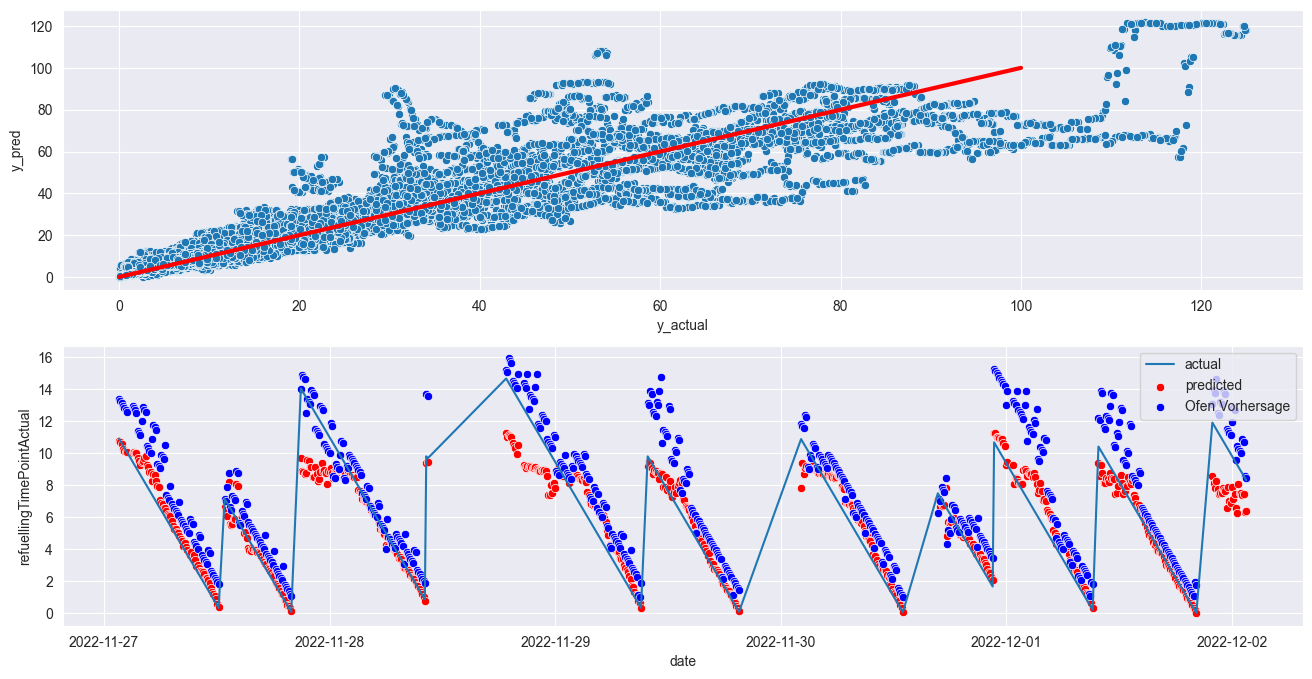

In [8]:
randomForestTrainer.visualize_split()

In [9]:
randomForestTrainer.train()

RandomForestRegressor(max_depth=20, max_features=None, min_samples_leaf=2,
                      min_samples_split=3, n_estimators=147)

## Feature Importance

Auch beim Random Forest Modell kann die Feature Importance betrachtet werden. Dabei ist zu beachten, dass die Werte nicht direkt vergleichbar sind, da die Skalierung der Feature-Bewertung unterschiedlich ist. Um den Fokus der Modelle vergleichbar zu machen, ist es jedoch ausreichend.

Insgesamt kann man feststellen, dass dieselben Features eine ähnlich hohe Relevanz für die Vorhersage in den beiden Modellen aufweisen.  

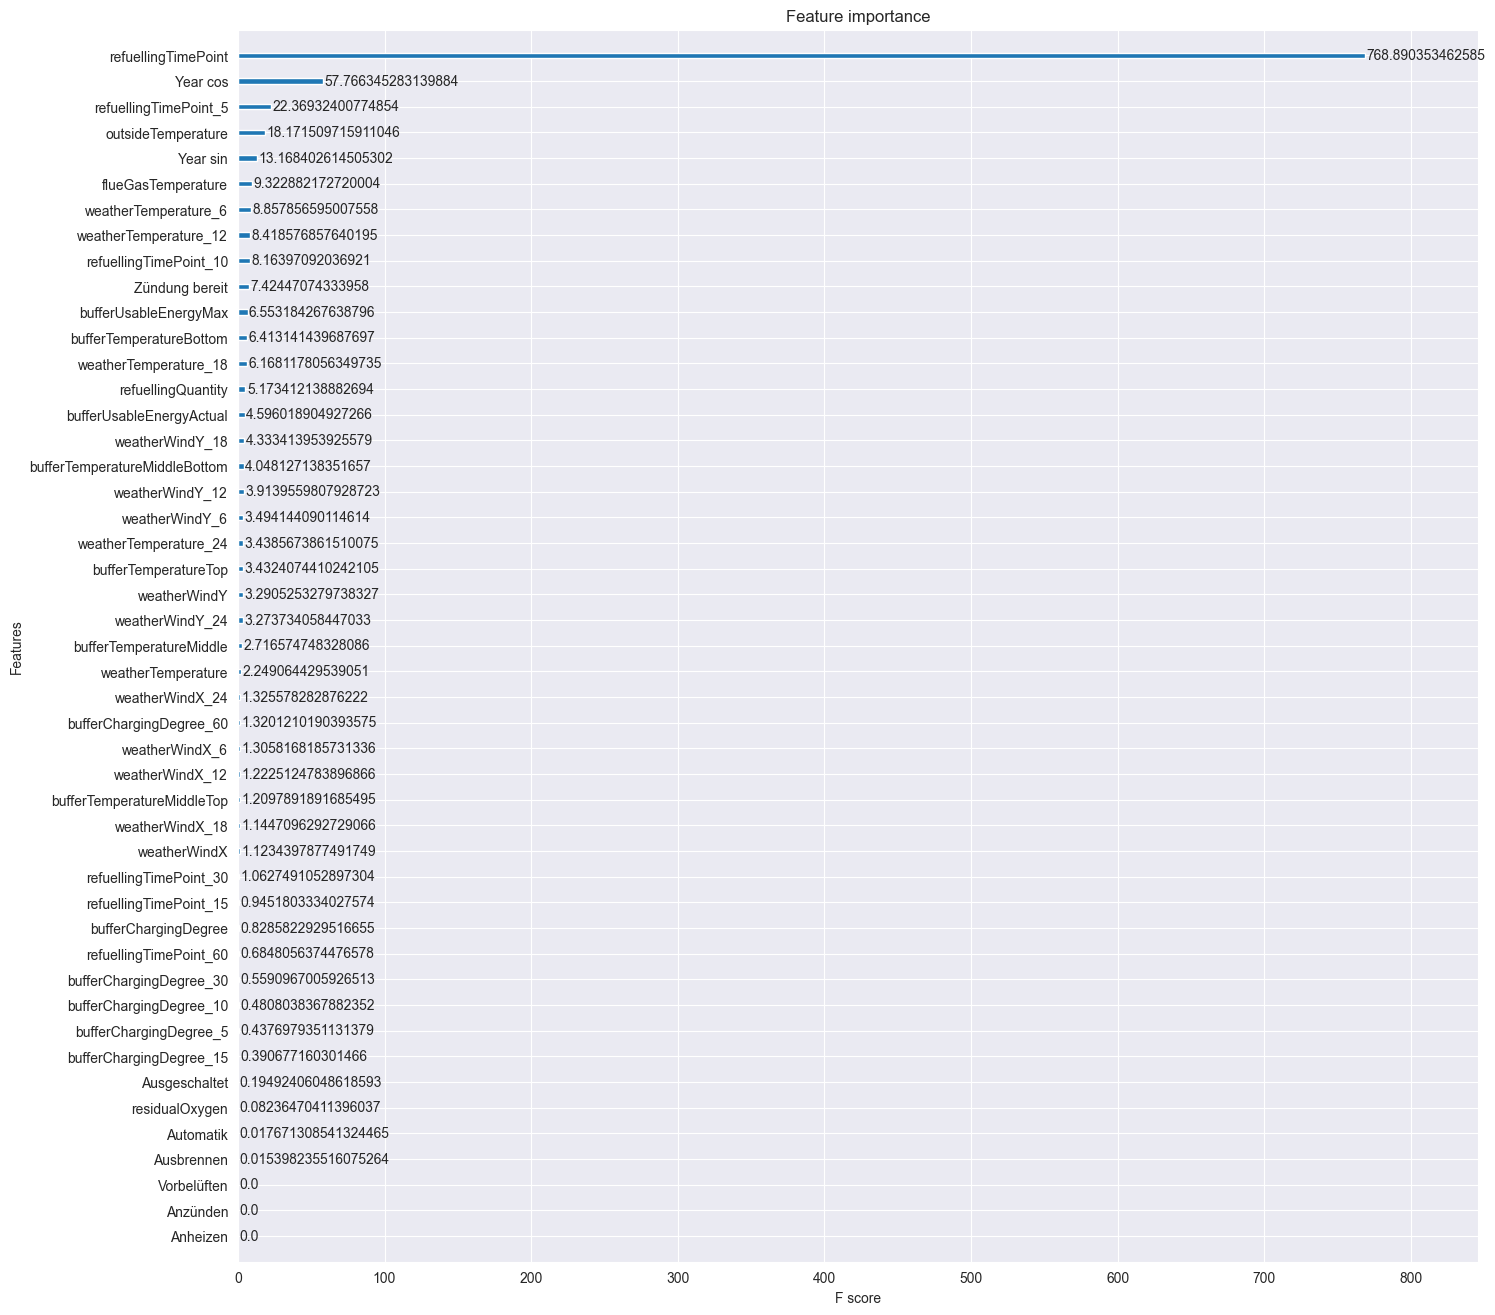

In [10]:
import xgboost as xgb

# combine input columns with feature importance into a dictionary
importance = dict(zip(input_columns, randomForestTrainer.model.feature_importances_ * 1000))

xgb.plot_importance(importance)
plt.gcf().set_size_inches(16, 16)